<a href="https://colab.research.google.com/github/jvallikivi/mlmi4-vcl/blob/main/Generative_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.distributions import kl_divergence, Normal
from collections import OrderedDict
from torchvision import datasets
from torchvision import transforms

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 0.001
batch_size = 50
n_epochs = 200

In [ ]:
class BayesLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight_loc = nn.Parameter(torch.zeros(in_features, out_features))
        self.log_weight_scale = nn.Parameter(torch.zeros(in_features, out_features))

        self.bias_loc = nn.Parameter(torch.zeros(out_features))
        self.log_bias_scale = nn.Parameter(torch.zeros(out_features))
        
        self.weight = self.weight_loc
        self.bias = self.bias_loc



    def get_params(self):
        """
        return two tensors, obtaining by concatenating locs and scales together
        these parameters can be further used to calculate e.g, KL divergence (vectorizedly)
        """
        return (
                torch.cat([self.weight_loc.flatten(), self.bias_loc.flatten()]), 
                torch.cat([self.log_weight_scale.flatten(), self.log_bias_scale.flatten()])
               )
    
    
    def forward(self, x, activition_fn=None):
        y = x @ self.weight + self.bias
        if activition_fn:
            return activition_fn(y)
        return y


In [ ]:
class Encoder(nn.Module):

    def __init__(self, 
                 input_size, 
                 in_features, 
                 out_features, 
                 n_layers,                 ):
        """
        """
        super(Encoder, self).__init__()
        self.x_to_h = nn.ModuleList( [self.get_layer(input_size, in_features, True)] + 
                                    [self.get_layer(in_features, in_features, True) for _ in range(n_layers - 1)]).to(device)
        self.head = nn.ModuleList([self.get_layer(in_features, out_features, True) for _ in range(n_layers - 1)]
                                    + [self.get_layer(in_features, out_features)]).to(device)


    def get_layer(self, in_feature, out_features, activation=False):
        layer = nn.Linear(in_feature, out_features)
        return layer

In [ ]:
class VCL_Generator(nn.Module):
    def __init__(self, previous_model, 
                 nencoder_layers=3, ndecoder_layers=1, 
                 z_dim=50, h_dim=500, x_dim=784, random_initialize=False):
        super().__init__()
        
        self.ndecoder_layers = ndecoder_layers
        self.z_dim = z_dim

        #######ENCODER PART

        self.encoder = Encoder(input_size=x_dim,
                                in_features=h_dim,
                                out_features=z_dim*2,
                                n_layers=nencoder_layers).to(device)
        self.x_to_h = self.encoder.x_to_h#.to(device)
        self.encoder_head = self.encoder.head[-1]#.to(device)

        ######GENERATOR PART


        self.decoder_head = nn.ModuleList([BayesLinear(z_dim, h_dim)] +
                                          [BayesLinear(h_dim, h_dim) for _ in range(self.ndecoder_layers)]).to(device) 
        self.h_to_x = nn.ModuleList([BayesLinear(h_dim, h_dim) for _ in range(self.ndecoder_layers)] +
                                    [BayesLinear(h_dim, x_dim)]).to(device)
        
        
        # define a layer dict
        self.layer_dict = OrderedDict()
        for ix, layer in enumerate(self.x_to_h):
            self.layer_dict[f'x_to_h_{ix}'] = layer

        for ix, layer in enumerate(self.h_to_x):
            self.layer_dict[f'h_to_x_{ix}'] = layer
        
        for ix, layer in enumerate(self.decoder_head):
            self.layer_dict[f'decoder_head_{ix}'] = layer

        self.layer_dict["encoder_head"] = self.encoder_head

        # just a sanity check 
        assert id(self.layer_dict[f"x_to_h_{0}"]) == id(self.x_to_h[0])
        
        
        with torch.no_grad():
            if previous_model != None:
                for key in self.layer_dict:
                    if "decoder_head" in key or "h_to_x" in key:
                        self.layer_dict[key].weight_loc.data = previous_model.layer_dict[key].weight_loc.data.clone()
                        self.layer_dict[key].bias_loc.data = previous_model.layer_dict[key].bias_loc.data.clone()
                        self.layer_dict[key].log_weight_scale.data  = previous_model.layer_dict[key].log_weight_scale.data.clone()
                        self.layer_dict[key].log_bias_scale.data  = previous_model.layer_dict[key].log_bias_scale.data.clone()
                    else:
                        self.layer_dict[key] = previous_model.layer_dict[key]
            if random_initialize:
                for layer in self.h_to_x + self.decoder_head:
                    layer.log_weight_scale = nn.Parameter(torch.ones(layer.log_weight_scale.shape, device=device) * -6)
                    layer.log_bias_scale = nn.Parameter(torch.ones(layer.log_bias_scale.shape, device=device) * -6)
                    torch.nn.init.xavier_uniform_(layer.weight_loc)
                    layer.weight = torch.nn.Parameter(torch.normal(layer.weight_loc, torch.exp(layer.log_weight_scale)))#.to(device)
                    layer.bias = torch.nn.Parameter(torch.normal(layer.bias_loc, torch.exp(layer.log_bias_scale)))#.to(device)
        
        if  previous_model != None:
            previous_locs, previous_logscales = previous_model.get_params()
            self.previous_model_locs = previous_locs
            self.previous_model_log_scales = previous_logscales
        else:
            self.previous_model_locs = None
            self.previous_model_log_scales = None


    def encoder_forward(self, x):
        for layer in self.x_to_h:
            x = layer(x)
            x = nn.ReLU()(x)
        o = self.encoder_head(x)
        return o[:, :self.z_dim], o[:, self.z_dim:]

    
    def decoder_forward(self, z):
        for layer in self.decoder_head:
            z = layer(z, nn.Sigmoid())
        for layer in self.h_to_x:
            z = layer(z, nn.Sigmoid())
        return z


    def get_params(self):  
        locs = []
        logscales = []
        for layer in self.h_to_x:
            loc, scale = layer.get_params()
            locs.append(loc)
            logscales.append(scale)
        return locs, logscales

    def calculate_loss(self, x, y, n_particles=10, dataset_size=6000):
        
        locs, logscales = self.get_params()
        # calculate KL between "prior" and posterior
        size = len(locs)
        kl = 0
        for ix in range(size):
            KL = kl_divergence(Normal(loc=locs[ix], scale=torch.exp(logscales[ix])),
                                Normal(loc=self.previous_model_locs[ix], scale=torch.exp(self.previous_model_log_scales[ix]))
                            )
            kl += KL.sum()/dataset_size 

        loc, log_scale = self.encoder_forward(x) 
        kl_z = kl_divergence(Normal(loc, torch.exp(log_scale)), 
                             Normal(0., torch.exp(torch.Tensor([0.]).to(device))))
        bce = 0.
        for _ in range(n_particles):
            z = torch.normal(loc, torch.exp(log_scale))
            gen = self.decoder_forward(z)	
            bce += -torch.nn.functional.binary_cross_entropy(gen, x)

        loss = (kl_z - bce).mean() + kl 
        return loss  

In [ ]:
## dataset
ds_test = datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
ds_train = datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)

def get_digit(task_idx=0, conv=False):
    #image normalization 255
    train_y = torch.tensor([d[1] for d in ds_train])
    test_y = torch.tensor([d[1] for d in ds_test])

    train_mask = train_y == task_idx
    test_mask = test_y == task_idx

    train_y = train_y[train_mask]
    test_y = test_y[test_mask]

    test_x = nn.Flatten()(torch.cat([d[0] for d in ds_test]))[test_mask]/255.
    train_x = nn.Flatten()(torch.cat([d[0] for d in ds_train]))[train_mask]/255.

    return train_x.to(device), train_y.to(device), test_x.to(device), test_y.to(device)

100%|██████████| 200/200 [07:55<00:00,  2.38s/it]


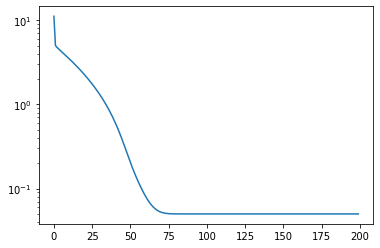

100%|██████████| 200/200 [08:37<00:00,  2.59s/it]


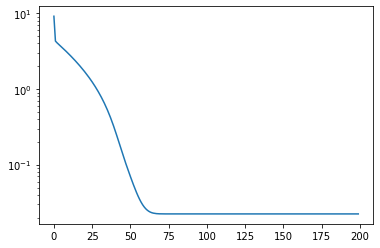

100%|██████████| 200/200 [07:35<00:00,  2.28s/it]


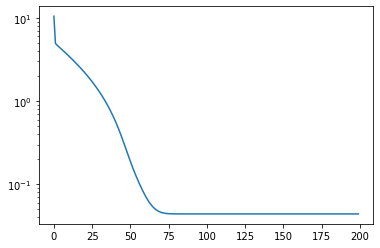

100%|██████████| 200/200 [07:44<00:00,  2.32s/it]


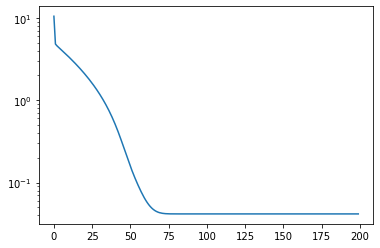

100%|██████████| 200/200 [07:26<00:00,  2.23s/it]


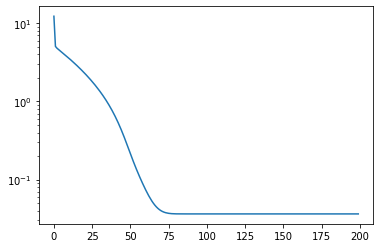

100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


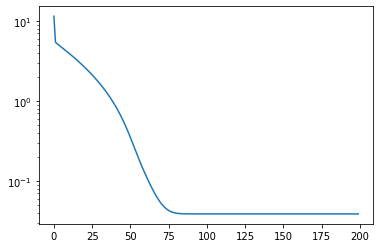

100%|██████████| 200/200 [07:25<00:00,  2.23s/it]


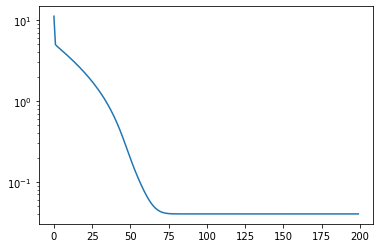

100%|██████████| 200/200 [07:49<00:00,  2.35s/it]


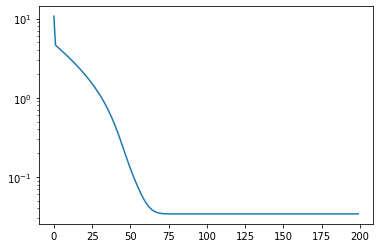

100%|██████████| 200/200 [07:17<00:00,  2.19s/it]


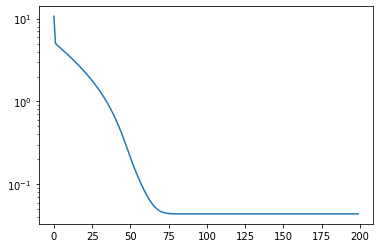

100%|██████████| 200/200 [07:26<00:00,  2.23s/it]


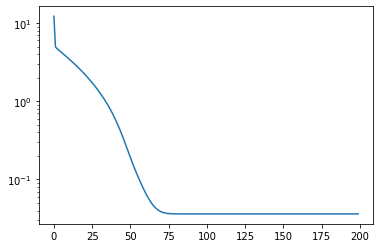

In [ ]:
import copy
previous_model = VCL_Generator(previous_model=None).to(device) # initialize a prior model
lr = 0.001
models = []
for digit_id in range(10): #
    train_x, train_y, test_x, test_y = get_digit(digit_id)
    current_model = VCL_Generator(previous_model=previous_model, random_initialize=True).to(device)
    current_opt = torch.optim.Adam(current_model.parameters(), lr=lr)
    train_losses = []
    dataset_size = train_x.shape[0]
    for epoch in tqdm(range(n_epochs)):
        loss_batch = []
        for batch in range(int(np.ceil(train_x.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            
            current_opt.zero_grad()
            loss = current_model.calculate_loss(x=train_x[batch_idx0: batch_idx1].to(device), 
                                                y=train_y[batch_idx0: batch_idx1].to(device), 
                                                n_particles=10,
                                                dataset_size=dataset_size
                                                )
            loss.backward()
            nn.utils.clip_grad_value_(current_model.parameters(), 5)
            current_opt.step()
            loss_batch.append(loss.item())
        train_losses.append(np.mean(loss_batch))
    plt.plot(train_losses)
    plt.yscale("log")
    plt.show()
    models.append(copy.copy(current_model))
    previous_model = current_model

In [ ]:
def generate_image(head, generator, z):
    with torch.no_grad():
        for layer in head:
            z = layer.forward(z, nn.Sigmoid())
        for layer in generator:
            z = layer.forward(z, nn.Sigmoid())
    z = z.detach().cpu()
    z = z.reshape((28, 28))
    return z

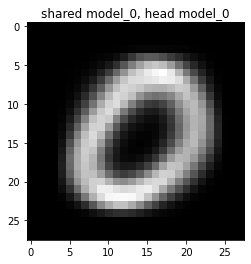

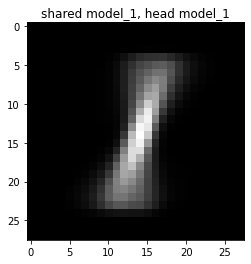

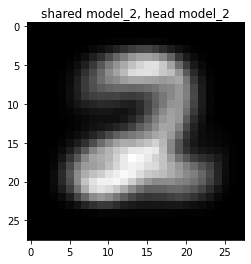

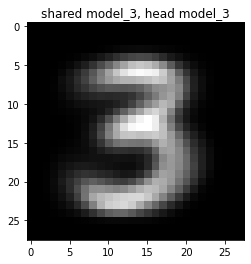

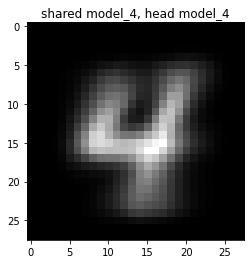

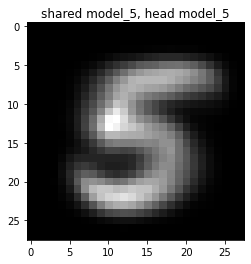

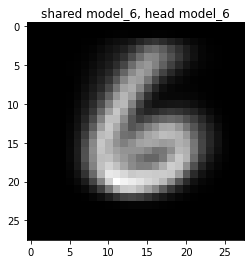

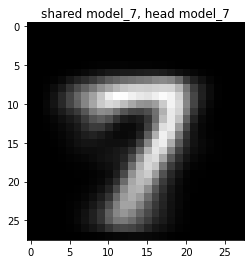

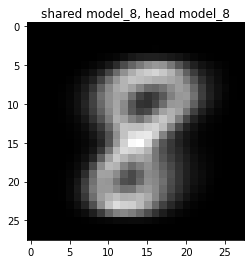

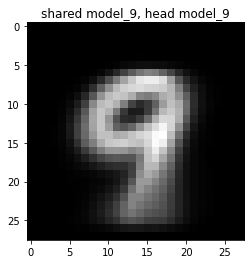

In [ ]:
for ix1, model1 in enumerate(models):
    z = torch.randn(1, 50).to(device)
    preds = model1.decoder_forward(z)
    plt.imshow(preds.detach().cpu().reshape(28, 28), cmap="gray")
    plt.title(f'shared model_{ix1}, head model_{ix1}')
    plt.show()

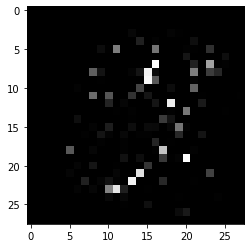

In [ ]:
z = torch.randn(1, 50).to(device)
with torch.no_grad():
    for layer in models[0].decoder_head:
        z = layer.forward(z, nn.Sigmoid())
    for layer in models[-5].h_to_x:
        z = layer.forward(z, nn.Sigmoid())
plt.imshow(z.detach().cpu().reshape(28, 28), cmap="gray")